<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Log</a></span></li></ul></li><li><span><a href="#Pickle" data-toc-modified-id="Pickle-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pickle</a></span><ul class="toc-item"><li><span><a href="#Everything" data-toc-modified-id="Everything-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Everything</a></span></li><li><span><a href="#Subset" data-toc-modified-id="Subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset</a></span></li></ul></li><li><span><a href="#DataLoaders" data-toc-modified-id="DataLoaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoaders</a></span></li><li><span><a href="#Model-&amp;-Loss-Function" data-toc-modified-id="Model-&amp;-Loss-Function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model &amp; Loss Function</a></span><ul class="toc-item"><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Architecture</a></span><ul class="toc-item"><li><span><a href="#Anchors" data-toc-modified-id="Anchors-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Anchors</a></span></li><li><span><a href="#Show" data-toc-modified-id="Show-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Show</a></span></li></ul></li><li><span><a href="#Working-with-a-batch-&amp;-generating-preds" data-toc-modified-id="Working-with-a-batch-&amp;-generating-preds-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Working with a batch &amp; generating preds</a></span><ul class="toc-item"><li><span><a href="#Converting-batch-bboxes-and-lbls-to-SSD-labels" data-toc-modified-id="Converting-batch-bboxes-and-lbls-to-SSD-labels-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Converting batch bboxes and lbls to SSD labels</a></span></li></ul></li><li><span><a href="#Loss" data-toc-modified-id="Loss-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Loss</a></span></li></ul></li></ul></div>

## Log

Video: https://www.youtube.com/watch?v=0frKXR-2PBY

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.

# Pickle

## Everything

In [ ]:
# from fastai.vision.all import *

# # paths
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'
# animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

# # get items & annos
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_paths, train_annos = get_annos(path, train_json, train_im_dir)
# valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
# paths  = train_paths + valid_paths
# annos  = train_annos + valid_annos
# bboxes = [a[0] for a in annos]
# lbls   = [a[1] for a in annos]

# # create df and pkl
# df = pd.DataFrame({
#     "path": paths,
#     "lbl":  lbls,
#     "bbox": bboxes,
#     "is_valid": [0]*len(train_files) + [1]*len(valid_files),
#     "n_items": L(len(l) for l in lbls)
#     })
# df.to_pickle(path/'20201027_coco_df.pkl')

# df.head(1)

## Subset

In [ ]:
# from fastai.vision.all import *
    
    
# # paths
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'
# animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

# # get items & annos
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_files, train_annos = get_annos(path, train_json, train_im_dir)
# valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
# annos = train_annos + valid_annos
# bboxes = L(L(b) for b,l in annos)
# lbls   = L(L(l) for b,l in annos)

# # get label subset
# def flatten(l):
#     def _recur(l,res):
#         for o in l:
#             if   isinstance(o,list): _recur(o,res)
#             elif isinstance(o,L)   : _recur(o,res)
#             else: res.append(o)
#         return res
#     return _recur(l, L())
# lbls_flat = flatten(lbls)
# def get_count(lbl): return len(lbls_flat.filter(lambda x: x==lbl))
# lbls_sorted = sorted(lbls_flat.unique(), key=get_count, reverse=True)
# lbl_cts = [(l, get_count(l)) for l in lbls_sorted]
# lbl_ss = [l for l,c in lbl_cts if 5000<c<30000]
# lbl_ss.remove('traffic light')
# lbl_ss.remove('motorcycle')
# lbl_ss.remove('bus')

# # get subset items & annos
# ss_idxs   = L(L(o in lbl_ss for o in l) for l in lbls)
# ss_lbls   = L(o[i] for o,i in zip(lbls,ss_idxs))
# ss_bboxes = L(o[i] for o,i in zip(bboxes,ss_idxs))
# ss_obj    = L(len(l) for l in ss_lbls)

# # create df
# df = pd.DataFrame({
#     "path"  : train_files + valid_files,
#     "lbl"   : ss_lbls,
#     "bbox"  : ss_bboxes,
#     "n_obj" : ss_obj
#     })

# # remove rows w/ 4+ objects per im
# # reduce value counts to a max of 2*min_vc
# too_many = 8
# rng = list(range(too_many))
# cts = list(df['n_obj'].value_counts())[:too_many]
# minv = min(cts)
# zipd = list(zip(*[rng,cts]))
# zipd[0] = (0, minv) # limit ims w/zero objs
# df = pd.concat([df[df['n_obj']==i].sample(n=min(s,minv*2)) for i,s in zipd])

# # create pkl
# df.to_pickle(path/'20201029_coco_ss_df.pkl')

# DataLoaders

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
path       = Path('/home/rory/data/coco2017')
valid_pct  = .10


### Items ###
df = pd.read_pickle(path/'20201029_coco_ss_df.pkl')
# get items
def get_cols(df,cols): return L(L(df[c].to_list()) for c in cols)
paths, bboxes, lbls  = get_cols(df, ['path', 'bbox', 'lbl'])
p2b = {p:b for p,b in zip(paths,bboxes)}
p2l = {p:l for p,l in zip(paths,lbls)}
def get_bbox(p): return p2b[p]
def get_lbl(p):  return p2l[p]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)
print("Training n:",int(len(df)*(1-valid_pct)))

Training n: 56857


# Model & Loss Function

Steps:
- ...

## Model Architecture

In [ ]:
# anchor params
k = 1
anc_grid = 4

In [ ]:
# 42:33
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [ ]:
# 42:33
def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2) # loss expects flat tensor

In [ ]:
# 42:33
class OutConv(nn.Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [ ]:
# 42:00
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv1(x)
        return self.out(x)

class custom_module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

In [ ]:
head_reg4 = SSD_Head(k, -3.)
body = create_body(resnet34, pretrained=True)
mod = custom_module(body, head_reg4)
learner = Learner(dls, mod)

### Anchors

Anchors are in [x-center, y-center, h, w] format. The following cell converts them to [x-topr, y-topr, x-botl, y-botl] format.

In [ ]:
# 41:43
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_hws = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
grid_sizes = tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1) # 0.25

def hw2bb(ctr,hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

anchor_boxes = hw2bb(anc_ctrs, anc_hws)

### Show

In [ ]:
def show_bb(im,bb,lbl=None,sz=224,figsize=[5,5],color='white',ctx=None,use_vocab=True,title=None):
    bboxes = TensorBBox((bb+1)*sz//2)
    if lbl!=None:
        if use_vocab==True:
            try: label = dls.vocab[lbl]
            except: label = lbl
        else: label = lbl
        lbboxes = LabeledBBox(bboxes, label)
    if ctx==None: ctx=show_image(im, figsize=figsize, title=title)
    else: show_image(im, figsize=figsize, title=title, ctx=ctx)
    if lbl!=None: lbboxes.show(ctx=ctx) # draw white bboxes and lbls
    bboxes.show(ctx=ctx, color=color) # draw colored bboxes over white bboxes
    return ctx

## Working with a batch & generating preds

JH uses b_clasi and b_bboxi for his model outputs (acts), and bbox and clas for his batch outputs.

In [ ]:
# grab batch and acts (52m)
batch = dls.one_batch()
b_ims, b_bboxes, b_lbls = batch

learner.model.eval()
acts = learner.model(b_ims.cpu())
a_bboxes, a_lbls = acts

Batch has three parts: `b_ims`, `b_bboxes`, `b_lbls`

In [ ]:
b_ims.shape, b_bboxes.shape, b_lbls.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 4]), torch.Size([64, 3]))

Acts has two parts: `a_bboxes`, `a_lbls` 

In [ ]:
a_bboxes.shape, a_lbls.shape

(torch.Size([64, 16, 4]), torch.Size([64, 16, 51]))

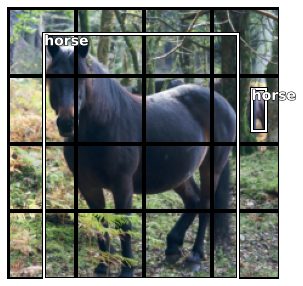

In [ ]:
# grab single im and its b_ & a_ bbox,lbl
idx=5

b_bbox = b_bboxes[idx].cpu()
b_lbl  = b_lbls[idx].cpu()

a_bbox = a_bboxes[idx]
a_lbl  = a_lbls[idx]

decoded_batch = dls.decode(batch)
d_im   = decoded_batch[0][idx]

# show im w/ targ, ancs
ctx = show_bb(d_im, anchor_boxes, color='black')
show_bb(d_im, b_bbox, b_lbl, ctx=ctx);

Shape of acts for a single im's prediction:
- `a_bbox` has 16 sets of 4 → 16 bboxes
- `a_lbl` has 16 sets of 51 → 16 sets of multi-label probabilities

In [ ]:
a_bbox.shape, a_lbl.shape

(torch.Size([16, 4]), torch.Size([16, 51]))

### Converting batch bboxes and lbls to SSD labels

In [ ]:
# 1:05:36

In [ ]:
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def bb_area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def get_iou(b1, b2):
    """Uses IOU (index over union) to calculate bbox overlaps."""
    inter = intersxn(b1,b2)
    union = bb_area(b1).unsqueeze(1) + bb_area(b2).unsqueeze(0) - inter
    return inter / union

In [ ]:
# Get overlaps | 58m
ious = get_iou(b_bbox, anchor_boxes)
ious

tensor([[0.0250, 0.0419, 0.0419, 0.0419, 0.0566, 0.0969, 0.0969, 0.0969, 0.0566,
         0.0969, 0.0969, 0.0969, 0.0222, 0.0372, 0.0372, 0.0372],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1303, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [ ]:
ious.max(1)

torch.return_types.max(
values=tensor([0.0969, 0.1303, 0.0000]),
indices=tensor([ 5, 13,  0]))

In [ ]:
ious.max(1)[0]

tensor([0.0969, 0.1303, 0.0000])

In [ ]:
ious.max(1)[0]!=0

tensor([ True,  True, False])

In [ ]:
ious.max(1)[1][ious.max(1)[0]!=0]

tensor([ 5, 13])

In [ ]:
# 1:04:40
def map_ancs_to_bbs(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

In [ ]:
max_iou_per_anchor, idx_of_bb = map_ancs_to_bbs(ious)
max_iou_per_anchor, idx_of_bb

(tensor([0.0250, 0.0419, 0.0419, 0.0419, 0.0566, 1.9900, 0.0969, 0.0969, 0.0566,
         0.0969, 0.0969, 0.0969, 0.0222, 1.9900, 0.0372, 0.0372]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]))

In [ ]:
targ_lbl = tensor(b_lbl[idx_of_bb], dtype=torch.int)
targ_lbl

tensor([27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
        27., 27.])

In [ ]:
# 1:01:40
thresh = 0.5
above_thresh = max_iou_per_anchor > thresh
assigned_idx = torch.nonzero(above_thresh).squeeze()
unassigned_idx = torch.nonzero(~above_thresh).squeeze()
assigned_idx

tensor([ 5, 13])

In [ ]:
targ_lbl[~above_thresh] = 0 # set vocab idx of unassigned ancs to 0 ('#na#')
targ_lbl

tensor([ 0.,  0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 27.,
         0.,  0.])

In [ ]:
# output labels (readable)
dls.vocab[targ_lbl]

(#16) ['#na#','#na#','#na#','#na#','#na#','horse','#na#','#na#','#na#','#na#'...]

In [ ]:
# project 16 bboxes from activations to anchor locations | 1:04:40
def acts_to_bb(a_bbox, anchors, grid_sizes):
    acts = torch.tanh(a_bbox) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * grid_sizes) # move ctrs by up to grid_sizes/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return hw2bb(ctrs, hws)

pred_bbox_all = acts_to_bb(a_bbox, anchors, grid_sizes)
pred_bbox = pred_bbox_all[assigned_idx]
pred_bbox

tensor([[-0.4948, -0.4689,  0.0052,  0.0219],
        [ 0.4647, -0.4852,  0.9743,  0.0110]], grad_fn=<IndexBackward>)

In [ ]:
# calc losses
targ_bbox_all = b_bbox[idx_of_bb]
targ_bbox = targ_bbox_all[assigned_idx]
loc_loss = ((pred_bbox - targ_bbox).abs()).mean()
lbl_loss = F.cross_entropy(a_lbl, targ_lbl.long())
loc_loss, lbl_loss

(tensor(0.3544, grad_fn=<MeanBackward0>),
 tensor(3.9023, grad_fn=<NllLossBackward>))

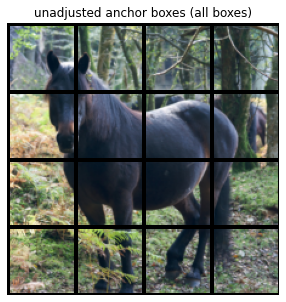

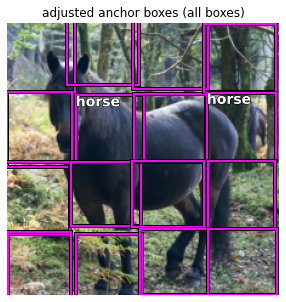

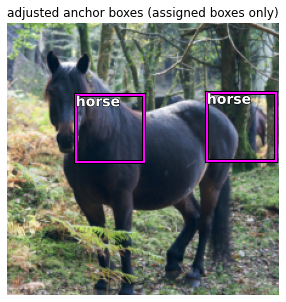

In [ ]:
# show anchor box progression
show_bb(d_im, anchor_boxes, color='black',
        title='unadjusted anchor boxes (all boxes)')
show_bb(d_im, pred_bbox_all, targ_lbl, color='magenta',
        title='adjusted anchor boxes (all boxes)')
show_bb(d_im, pred_bbox, targ_lbl[assigned_idx], color='magenta',
        title='adjusted anchor boxes (assigned boxes only)');

## Loss

1:06:00

In [ ]:
def one_hot_embedding(labels, n_classes):
    return torch.eye(n_classes)[labels.data.cpu()]

In [ ]:
class BCE_Loss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = V(t[:,1:].contiguous()) # first class is #na# so skip it
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x,t,w,size_average=False)/self.num_classes
    
    def get_weight(self, x, t): return None
    
loss_f = BCE_Loss(len(dls.vocab))

In [ ]:
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def bb_area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    """Uses IOU (index over union) to calculate bbox overlaps."""
    inter = intersxn(b1,b2)
    union = bb_area(b1).unsqueeze(1) + bb_area(b2).unsqueeze(0) - inter
    return inter / union

In [ ]:
b_bbox,b_lbl

(tensor([[-0.7278, -0.8029,  0.7029,  1.0000],
         [ 0.7999, -0.3961,  0.9060, -0.0889],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([27., 27.,  0.]))

In [ ]:
remove_padding(b_bbox,b_lbl)

(tensor([[-0.7278, -0.8029,  0.7029,  1.0000],
         [ 0.7999, -0.3961,  0.9060, -0.0889]]),
 tensor([27., 27.]))

In [ ]:
# 1:04:40
def remove_padding(bb, lbl):
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]

def adjust_anchor_boxes(act_bbs, anchors, grid_sizes):
    acts = torch.tanh(act_bbs) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * grid_sizes) # move ctrs by up to grid_sizes/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return hw2bb(ctrs, hws)

def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

def ssd_item_loss(act_bb, act_lbl, bb, lbl): # 1:10:00
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, grid_sizes)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4 # boolean list; True if anc > thresh
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx]
    bb_loss = ((pred_bb[assigned_idx] - targ_bb[assigned_idx]).abs()).mean() # L1
    lbl_loss = loss_f(act_lbl, targ_lbl)
    return bb_loss, lbl_loss

def ssd_loss(acts, targs):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for act_bb,act_lbl,bb,lbl in zip(*acts, *targs):
        bb_loss,lbl_loss = ssd_item_loss(act_bb,act_lbl,bb,lbl)
        sum_bb_loss += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

In [ ]:
# 26:09
def bb_hw(b): return np.array(b[1], b[0], b[3]-b[1], b[2]-b[0])

In [ ]:
# 41:41
# mc, id2cat, cat2id, mcs

# 51:53
# val_idxs, mbb, mbbs, df

# 51:58
# x,y , batch, b_clas, b_bb, idx, b_clasi, b_bboxi, ima, bbox, clas